In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_log_error


In [51]:
sber = pd.read_csv('/Users/vadimsmirnov/Desktop/python_project_hse/data/sber.csv')

In [52]:
sber.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-03,255.97,258.19,253.70,255.00,35824160
1,2020-01-06,254.75,254.84,251.40,253.90,22327940
2,2020-01-08,253.62,259.15,253.03,259.15,40736030
3,2020-01-09,259.41,261.76,257.01,257.99,38196300
4,2020-01-10,257.91,259.25,256.88,258.19,18841650


In [53]:
sber.shape

(1078, 6)

In [54]:

class stock_predict_DL:
    def __init__(self, df):
        # We are taking only the Close prices for predicting 
        data = df['Close']
        dataset = data.values.reshape(-1,1)
        print(f"Shape of dataset: {dataset.shape}")

        # We take 90% of the data for training and 10% for testing 
        training_data_len = int(np.ceil(len(dataset) * 0.90))
        # We are scaling the close prices to the range(0,1)
        self.scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = self.scaler.fit_transform(dataset)

        print(f'train_len: {training_data_len}')
        print(f'Shape of scaled_data: {scaled_data.shape}')
        # Taking the first 90% of the dataset for training 
        train_data = scaled_data[0:int(training_data_len), :]
        # Split the data into self.X_train and self.y_train data sets
        self.X_train = []
        self.y_train = []
        print(f'train_data.shape: {train_data.shape}')
        
        # We are predicting the close price of a given day based on the trend in the previous 60 days
        for i in range(60, len(train_data)):
            self.X_train.append(train_data[i-60:i, 0])
            self.y_train.append(train_data[i, 0])

        # Convert the self.X_train and self.y_train to numpy arrays 
        self.X_train, self.y_train = np.array(self.X_train), np.array(self.y_train)
        
        print(f'Shape of X_train, y_train: {self.X_train.shape, self.y_train.shape}')
        
        # Create the testing data set
        # Create a new array containing scaled values from the training_data_len - 60 to the end 
        test_data = scaled_data[training_data_len - 60:, :]
        # Create the data sets self.X_test and self.y_test
        self.X_test = []
        # Remaining 10% of the data needs to be given for testing 
        self.y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            self.X_test.append(test_data[i-60:i, 0])

        # Convert the data to a numpy array
        self.X_test = np.array(self.X_test)
        test_dates = df['Date'].values
        print(f'Shape of X_test, y_test: {self.X_test.shape, self.y_test.shape}')
        self.testd = test_dates[training_data_len:] # stores the test dates
        print(f'Shape of testd: {self.testd}')
        # List to store the R2 scores of all the models to get the best model at the end
        self.model_score = []

    def LSTM_model(self):
        class LSTM(nn.Module):
            def __init__(self):
                super(LSTM, self).__init__()
                self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
                self.dropout1 = nn.Dropout(0.2)
                self.lstm2 = nn.LSTM(input_size=128, hidden_size=50, batch_first=True)
                self.dropout2 = nn.Dropout(0.2)
                self.fc1 = nn.Linear(50, 32)
                self.dropout3 = nn.Dropout(0.2)
                self.fc2 = nn.Linear(32, 1)

            def forward(self, x):
                x, _ = self.lstm1(x)
                x = self.dropout1(x)
                x, _ = self.lstm2(x)
                x = self.dropout2(x)
                x = self.fc1(x[:, -1, :])
                x = self.dropout3(x)
                x = self.fc2(x)
                return x

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = LSTM().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        Xtrain = torch.from_numpy(self.X_train).float().unsqueeze(-1).to(device)
        ytrain = torch.from_numpy(self.y_train).float().unsqueeze(-1).to(device)
        Xtest = torch.from_numpy(self.X_test).float().unsqueeze(-1).to(device)

        model.train()
        num_epochs = 100  # Increase the number of epochs
        batch_size = 32  # Using a batch size
        for epoch in range(num_epochs):
            permutation = torch.randperm(Xtrain.size()[0])
            for i in range(0, Xtrain.size()[0], batch_size):
                indices = permutation[i:i + batch_size]
                batch_x, batch_y = Xtrain[indices], ytrain[indices]
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Calculate R2 score on training data
        model.eval()
        with torch.no_grad():
            train_predictions = model(Xtrain).cpu().numpy()

        train_predictions = self.scaler.inverse_transform(train_predictions)
        r2_score_train = metrics.r2_score(self.scaler.inverse_transform(ytrain.cpu().numpy()), train_predictions)
        print("R2 SCORE on Training Data")
        print(r2_score_train)
        
        # Calculate R2 score on test data
        model.eval()
        with torch.no_grad():
            predictions = model(Xtest).cpu().numpy()

        predictions = self.scaler.inverse_transform(predictions)
        print("R2 SCORE")
        r2_score_test = metrics.r2_score(self.y_test, predictions)
        print(r2_score_test)
        self.model_score.append(["LSTM", r2_score_test])
        
        print("MSLE")
        print(metrics.mean_squared_log_error(self.y_test, predictions))

        plt.plot(predictions, label="Predicted")
        plt.plot(self.y_test, label="Observed")
        plt.legend() 

        # Ensure the number of xticks and labels match
        xticks = range(0, len(self.y_test), 50)
        if len(xticks) > len(self.testd):
            xticks = xticks[:len(self.testd)]
        plt.xticks(xticks, self.testd[:len(xticks)], rotation=45)

        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Price', fontsize=18)
        plt.title("LSTM")
        plt.show()

        #Save the model's state dicitonary
        
        save_model_lstm = torch.save(model.state_dict(), '/Users/vadimsmirnov/Desktop/python_project_hse/model/lstm/lstm_model_state_dict.pth')

        print("Model saved to {}".format(save_model_lstm))

        # Save test data and predictions to CSV
        results_df = pd.DataFrame({
            'Date': self.testd,  # Assuming self.testd contains date information
            'Actual': self.y_test.flatten(),  # Flatten to match shape for concatenation
            'Predicted': predictions.flatten()  # Flatten predictions array
        })

        # Save to CSV
        results_df.to_csv('/Users/vadimsmirnov/Desktop/python_project_hse/data_predicted/lstm/test_vs_predicted.csv', index=False)

        # Print confirmation message
        print("Test data and predicted data saved to 'test_vs_predicted.csv'")


Shape of dataset: (1078, 1)
train_len: 971
Shape of scaled_data: (1078, 1)
train_data.shape: (971, 1)
Shape of X_train, y_train: ((911, 60), (911,))
Shape of X_test, y_test: ((107, 60), (107, 1))
Shape of testd: ['2023-11-30' '2023-12-01' '2023-12-04' '2023-12-05' '2023-12-06'
 '2023-12-07' '2023-12-08' '2023-12-11' '2023-12-12' '2023-12-13'
 '2023-12-14' '2023-12-15' '2023-12-18' '2023-12-19' '2023-12-20'
 '2023-12-21' '2023-12-22' '2023-12-25' '2023-12-26' '2023-12-27'
 '2023-12-28' '2023-12-29' '2024-01-03' '2024-01-04' '2024-01-05'
 '2024-01-08' '2024-01-09' '2024-01-10' '2024-01-11' '2024-01-12'
 '2024-01-15' '2024-01-16' '2024-01-17' '2024-01-18' '2024-01-19'
 '2024-01-22' '2024-01-23' '2024-01-24' '2024-01-25' '2024-01-26'
 '2024-01-29' '2024-01-30' '2024-01-31' '2024-02-01' '2024-02-02'
 '2024-02-05' '2024-02-06' '2024-02-07' '2024-02-08' '2024-02-09'
 '2024-02-12' '2024-02-13' '2024-02-14' '2024-02-15' '2024-02-16'
 '2024-02-19' '2024-02-20' '2024-02-21' '2024-02-22' '2024-02-

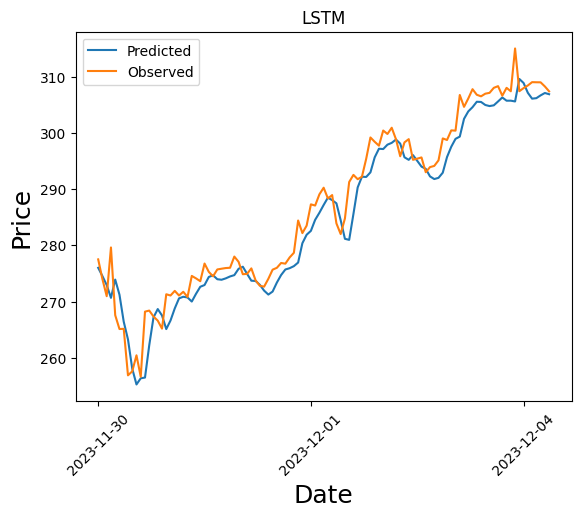

Model saved to None
Test data and predicted data saved to 'test_vs_predicted.csv'


In [55]:
someclass2 = stock_predict_DL(sber)
someclass2.LSTM_model()

In [43]:
lstm_df = pd.read_csv('/Users/vadimsmirnov/Desktop/python_project_hse/test_vs_predicted.csv')